# Installing and importing required modules

In [1]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 32.8 MB/s 


In [2]:
!pip install torch_pruning==0.2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import models,transforms,datasets
import torch.nn.utils.prune as prune
from copy import deepcopy
import torch_pruning as tp

# To time everything
%load_ext autotime

time: 248 µs (started: 2022-11-23 16:21:37 +00:00)


In [4]:
# Setting up GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

time: 74.5 ms (started: 2022-11-23 16:21:37 +00:00)


# Import CIFAR-100 and Resize

In [5]:
# Transforming the CIFAR100 train dataset and test dataset
train_transform = transforms.Compose([transforms.Resize(64),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

test_transform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

time: 2.16 ms (started: 2022-11-23 16:21:38 +00:00)


In [6]:
train_data_set = datasets.CIFAR100(root = "CIFAR100", train = True, download = True, transform = train_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting CIFAR100/cifar-100-python.tar.gz to CIFAR100
time: 5.53 s (started: 2022-11-23 16:21:38 +00:00)


In [7]:
test_data_set = datasets.CIFAR100(root = "CIFAR100", train = False, download = True, transform = test_transform)

Files already downloaded and verified
time: 1.07 s (started: 2022-11-23 16:21:43 +00:00)


In [8]:
train_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 104 ms (started: 2022-11-23 16:21:44 +00:00)


In [9]:
test_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 17 ms (started: 2022-11-23 16:21:44 +00:00)


# VGG16

In [10]:
# Defining number of classes in the dataset
n_classes = 100

# Defining the Batch size for training
batch_size = 64

# Defining Number of epochs
n_epochs = 15

time: 816 µs (started: 2022-11-23 16:21:44 +00:00)


In [11]:
vgg16_model = models.vgg16(pretrained = True) #130million+ parameters

# set_parameter_requires_grad for classifier layers
'''
for param in vgg16_model.parameters():
  param.requires_grad=False
'''

# Modifying last layer out classes
vgg16_model.classifier[6].out_features = n_classes

vgg16_model = vgg16_model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

time: 12.6 s (started: 2022-11-23 16:21:44 +00:00)


In [12]:
# Printing VGG16 Model
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training

In [13]:
# To compute the cross entropy loss between input and target
criterion = nn.CrossEntropyLoss()

# To implement stochastic gradient descent and optimize the model
sgd_optimizer = optim.SGD(vgg16_model.parameters(), lr = 0.003, momentum = 0.9)

# Decays the learning rate of each parameter group by gamma every step_size epochs
lr_scheduler = optim.lr_scheduler.StepLR(sgd_optimizer, step_size = 15, gamma = 0.1)

# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader  = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader   = DataLoader(test_data_set, batch_size = batch_size, shuffle = True)

time: 2.09 ms (started: 2022-11-23 16:21:57 +00:00)


In [14]:
# Method to train the model
def fit(model, dataset, optimizer, scheduler, criterion):
  # Set model to training mode
  model.train()
  if scheduler != None:
    scheduler.step()
  # Iterating over the data
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    # Reset the gradients
    optimizer.zero_grad()
    # Generate predictions
    pred  = model(data)
    # Calculate loss
    loss  = criterion(pred, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()

time: 1.75 ms (started: 2022-11-23 16:21:57 +00:00)


In [15]:
from os import pread
# Method to validate the model
def validate(model, dataset, criterion):
  # Set model to evaluation mode
  model.eval()
  accuracy  = 0
  loss      = []
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    pred    = model(data)
    # Get loss
    l = criterion(pred, targets)
    loss.append(l.item())
    # Get index of class label
    _,preds = torch.max(pred.data,1)
    # Get accuracy
    accuracy += torch.sum(preds == targets).item()

  return 100*accuracy/len(dataset.dataset), np.mean(np.array(loss))

time: 1.51 ms (started: 2022-11-23 16:21:57 +00:00)


In [16]:
# train_loss  = []
# train_acc   = []
# test_loss   = []
# test_acc    = []
# epochs      = []
# epoch_value = 0

# # Loop for n_epochs
# for epoch in range(n_epochs):
#   # Fit model
#   fit(vgg16_model, train_dataloader, sgd_optimizer, lr_scheduler, criterion)

#   # Train validation
#   train_accuracy, train_lss = validate(vgg16_model, train_dataloader, criterion)
#   train_loss.append(train_lss)
#   train_acc.append(train_accuracy)

#   # Test validation
#   test_accuracy, test_lss = validate(vgg16_model, test_dataloader, criterion)
#   test_loss.append(test_lss)
#   test_acc.append(test_accuracy)

#   # Printing the epochs with 
#   print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{train_loss[-1]:.4f}\t Train_Acc:{train_acc[-1]:.4f}\t Test_Loss:{test_loss[-1]:.4f}\t Test_Acc:{test_acc[-1]:.4f}')
#   epoch_value +=1
#   epochs.append(epoch_value)


time: 464 µs (started: 2022-11-23 16:21:57 +00:00)


In [17]:
# # Plotting Epoch vs Test Loss
# print('Test Loss: ', test_loss)
# print('Epochs: ', epochs)

# plt.plot(test_loss, epochs)
# plt.ylabel('epochs')
# plt.xlabel('Test Loss')

time: 741 µs (started: 2022-11-23 16:21:57 +00:00)


# Save VGG16 Model

In [18]:
# # Authorizing Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

time: 566 µs (started: 2022-11-23 16:21:57 +00:00)


In [19]:
# # Saving the model to Drive
# path = F"/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0"
# torch.save(vgg16_model.state_dict(), path)

time: 376 µs (started: 2022-11-23 16:21:57 +00:00)


In [20]:
# # Checking the GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

time: 378 µs (started: 2022-11-23 16:21:57 +00:00)


# Important Functions

In [21]:
# Method to remove parameters
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
    return model

time: 2.41 ms (started: 2022-11-23 16:21:57 +00:00)


In [22]:
# Method for unstructured pruning
def unstructured_global_pruning(model, amount):
  pruning_model = deepcopy(model)
  pruning_model = pruning_model.to(device)

  parameters_to_prune = []
  for module_name, module in pruning_model.named_modules():
      if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))

  prune.global_unstructured(
      parameters = parameters_to_prune,
      pruning_method = prune.L1Unstructured,
      amount = amount)

  pruning_model = remove_parameters(model = pruning_model)

  return pruning_model

time: 2.08 ms (started: 2022-11-23 16:21:57 +00:00)


In [23]:
# Method to evaluated the loss and accuracy of the model
def evaluate(model, dataloader):
  model.eval()
  acc = 0
  loss = []
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)
    out = model(data)
    #Get loss
    l = criterion(out, targets)
    loss.append(l.item())
    #Get index of class label
    _,preds = torch.max(out.data,1)
    #Get accuracy
    acc += torch.sum(preds == targets).item()

  return 100*acc/len(dataloader.dataset), np.mean(np.array(loss))

time: 1.43 ms (started: 2022-11-23 16:21:57 +00:00)


In [24]:
# Method to measure module sparsity
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    n_zeros = 0
    n_elements = 0
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()
            if "bias" in param_name and bias == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 1.72 ms (started: 2022-11-23 16:21:57 +00:00)


In [25]:
# Method to measure Global sparsity
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    n_zeros = 0
    n_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 1.34 ms (started: 2022-11-23 16:21:57 +00:00)


In [26]:
# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data_set, batch_size = batch_size)

time: 924 µs (started: 2022-11-23 16:21:57 +00:00)


# Import Model to be Pruned

In [27]:
vgg16_model = models.vgg16(pretrained = False)
vgg16_model.classifier[6].out_features = n_classes

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


time: 1.77 s (started: 2022-11-23 16:21:57 +00:00)


In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 17.5 s (started: 2022-11-23 16:21:59 +00:00)


In [29]:
vgg16_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0'))

<All keys matched successfully>

time: 4.7 s (started: 2022-11-23 16:22:16 +00:00)


In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

time: 128 ms (started: 2022-11-23 16:22:21 +00:00)


In [31]:
next(vgg16_model.parameters()).is_cuda

True

time: 4.58 ms (started: 2022-11-23 16:22:21 +00:00)


In [32]:
# Measuring Global Sparsity for VGG16 Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            vgg16_model,
            weight=True,
            bias=False,
            conv2d_use_mask=False,
            linear_use_mask=False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.00
time: 31.9 ms (started: 2022-11-23 16:22:21 +00:00)


# Unstructured Pruning

In [33]:
ustp_model = unstructured_global_pruning(vgg16_model, 0.8)

time: 401 ms (started: 2022-11-23 16:22:21 +00:00)


In [34]:
next(ustp_model.parameters()).is_cuda

True

time: 5.05 ms (started: 2022-11-23 16:22:22 +00:00)


In [35]:
acc, loss = evaluate(ustp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  74.28 	Loss :  1.0741185314336401
time: 13.7 s (started: 2022-11-23 16:22:22 +00:00)


In [36]:
# Measuring Global Sparsity for Unstructured Pruning Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            ustp_model,
            weight  = True,
            bias    = False,
            conv2d_use_mask = False,
            linear_use_mask = False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.80
time: 16.9 ms (started: 2022-11-23 16:22:36 +00:00)


In [37]:
# Measuring Sparsity for each layer
sparsity_layer = []
i = 0
layer = []
for module_name, module in ustp_model.named_modules():
  if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
    num_zeros, num_elements, sparsity = measure_module_sparsity(module, weight=True, bias=False, use_mask=False)
    print('Layer', i , num_zeros, num_elements, sparsity)
    sparsity_layer.append(sparsity)
    layer.append(i)
    i+= 1

Layer 0 56 1728 0.032407407407407406
Layer 1 6081 36864 0.16495768229166666
Layer 2 12449 73728 0.1688503689236111
Layer 3 29101 147456 0.1973537868923611
Layer 4 68043 294912 0.23072306315104166
Layer 5 164093 589824 0.2782067192925347
Layer 6 160281 589824 0.2717437744140625
Layer 7 373458 1179648 0.3165842692057292
Layer 8 929979 2359296 0.3941764831542969
Layer 9 934632 2359296 0.396148681640625
Layer 10 897492 2359296 0.3804066975911458
Layer 11 905980 2359296 0.3840043809678819
Layer 12 995514 2359296 0.42195383707682294
Layer 13 93590467 102760448 0.9107635167180276
Layer 14 10156255 16777216 0.6053599715232849
Layer 15 1451421 4096000 0.354350830078125
time: 48.5 ms (started: 2022-11-23 16:22:36 +00:00)


Sparsity:  [0.032407407407407406, 0.16495768229166666, 0.1688503689236111, 0.1973537868923611, 0.23072306315104166, 0.2782067192925347, 0.2717437744140625, 0.3165842692057292, 0.3941764831542969, 0.396148681640625, 0.3804066975911458, 0.3840043809678819, 0.42195383707682294, 0.9107635167180276, 0.6053599715232849, 0.354350830078125]
Layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Sparsity')

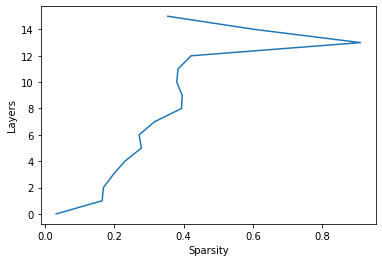

time: 229 ms (started: 2022-11-23 16:22:36 +00:00)


In [38]:
# Plotting Sparsity vs Layers
print('Sparsity: ', sparsity_layer)
print('Layers: ', layer)

plt.plot(sparsity_layer, layer)
plt.ylabel('Layers')
plt.xlabel('Sparsity')

# Structured Pruning

In [39]:
def structured_pruning(model, sparsity_layer):
  prune_model = deepcopy(model)
  prune_model = prune_model.to(device)

  prunable_module_type = (nn.Conv2d, nn.Linear)
  prunable_modules = [ m for m in prune_model.modules() if isinstance(m, prunable_module_type) ]

  strategy = tp.strategy.L1Strategy()
  DG = tp.DependencyGraph().build_dependency(prune_model, example_inputs = torch.randn(1,3,64,64))

  i = 0
  for layer_to_prune in prunable_modules:
    if isinstance( layer_to_prune, nn.Conv2d ):
        prune_fn = tp.prune_conv
    elif isinstance(layer_to_prune, nn.Linear):
        prune_fn = tp.prune_linear
    
    pruning_idxs = strategy(layer_to_prune.weight, amount = sparsity_layer[i])
    plan = DG.get_pruning_plan( layer_to_prune, prune_fn, pruning_idxs)

    i += 1

    plan.exec()
  
  return prune_model

time: 1.69 ms (started: 2022-11-23 16:22:36 +00:00)


In [40]:
stp_model = structured_pruning(ustp_model, sparsity_layer)

time: 1.37 s (started: 2022-11-23 16:22:36 +00:00)


In [41]:
tp.utils.count_params(stp_model)

12141667

time: 5.1 ms (started: 2022-11-23 16:22:37 +00:00)


In [42]:
stp_model.classifier[6].out_features = 100
print(stp_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(62, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(54, 107, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(107, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(103, 197, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(197, 185, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(185, 187, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [43]:
stp_model = stp_model.to(device)
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  5.59 	Loss :  4.495658479678403
time: 6.76 s (started: 2022-11-23 16:22:37 +00:00)


# Fine Tuning

In [44]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.001, momentum = 0.9)
epochs = 10

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch: 1	 Train_Loss:1.0825	 Train_Acc:68.1020	 Test_Loss:1.3296	 Test_Acc:61.7100
Epoch: 2	 Train_Loss:0.7660	 Train_Acc:77.3480	 Test_Loss:1.1554	 Test_Acc:67.3200
Epoch: 3	 Train_Loss:0.6486	 Train_Acc:80.4680	 Test_Loss:1.1146	 Test_Acc:68.9100
Epoch: 4	 Train_Loss:0.5680	 Train_Acc:82.6600	 Test_Loss:1.1154	 Test_Acc:70.0900
Epoch: 5	 Train_Loss:0.5148	 Train_Acc:84.3440	 Test_Loss:1.1142	 Test_Acc:70.4000
Epoch: 6	 Train_Loss:0.4645	 Train_Acc:85.4060	 Test_Loss:1.1414	 Test_Acc:70.5400
Epoch: 7	 Train_Loss:0.4536	 Train_Acc:85.9820	 Test_Loss:1.2155	 Test_Acc:70.1100
Epoch: 8	 Train_Loss:0.3847	 Train_Acc:88.0760	 Test_Loss:1.1261	 Test_Acc:71.4100
Epoch: 9	 Train_Loss:0.3522	 Train_Acc:89.0120	 Test_Loss:1.1774	 Test_Acc:71.8500
Epoch:10	 Train_Loss:0.3247	 Train_Acc:89.9220	 Test_Loss:1.1465	 Test_Acc:72.1000
time: 16min 59s (started: 2022-11-23 16:22:44 +00:00)


In [45]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.0001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+11:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:11	 Train_Loss:0.2374	 Train_Acc:92.5840	 Test_Loss:1.1544	 Test_Acc:73.5600
Epoch:12	 Train_Loss:0.2205	 Train_Acc:93.0360	 Test_Loss:1.1597	 Test_Acc:73.8100
Epoch:13	 Train_Loss:0.2100	 Train_Acc:93.4580	 Test_Loss:1.1679	 Test_Acc:73.9500
Epoch:14	 Train_Loss:0.2061	 Train_Acc:93.5200	 Test_Loss:1.1802	 Test_Acc:74.0200
Epoch:15	 Train_Loss:0.1971	 Train_Acc:93.8000	 Test_Loss:1.1852	 Test_Acc:73.7500
time: 8min 21s (started: 2022-11-23 16:39:43 +00:00)


In [46]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.00001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None , criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+16:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:16	 Train_Loss:0.1911	 Train_Acc:93.9160	 Test_Loss:1.1832	 Test_Acc:74.0800
Epoch:17	 Train_Loss:0.1900	 Train_Acc:93.9560	 Test_Loss:1.1863	 Test_Acc:74.1600
Epoch:18	 Train_Loss:0.1895	 Train_Acc:94.0020	 Test_Loss:1.1915	 Test_Acc:74.1100
Epoch:19	 Train_Loss:0.1871	 Train_Acc:94.1100	 Test_Loss:1.1924	 Test_Acc:74.2000
Epoch:20	 Train_Loss:0.1911	 Train_Acc:93.9940	 Test_Loss:1.1917	 Test_Acc:74.2700
time: 8min 17s (started: 2022-11-23 16:48:05 +00:00)


In [47]:
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  74.27 	Loss :  1.1917258451698691
time: 6.03 s (started: 2022-11-23 16:56:23 +00:00)


In [60]:
torch.save(stp_model, 'pruned_model.pt')

time: 102 ms (started: 2022-11-23 17:26:12 +00:00)


In [61]:
import sys
sys.getsizeof('pruned_model.pt')

64

time: 3.17 ms (started: 2022-11-23 17:26:14 +00:00)


In [62]:
import os
pruned_model_size = os.path.getsize('pruned_model.pt')
print("Pruned Model Size is :", pruned_model_size/(1024*1024), "mb")

Pruned Model Size is : 46.33374500274658 mb
time: 876 µs (started: 2022-11-23 17:26:17 +00:00)


In [63]:
original_model_size = os.path.getsize('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0')
print("Original VGG16 Model Size is :", original_model_size/(1024*1024), "mb")

Original VGG16 Model Size is : 527.8022508621216 mb
time: 2.46 ms (started: 2022-11-23 17:26:19 +00:00)


In [64]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3 s (started: 2022-11-23 17:26:29 +00:00)


In [65]:
vgg16_model_2 = models.vgg16(pretrained = False)

time: 4.05 s (started: 2022-11-23 17:26:38 +00:00)


In [1]:
# from pytorch_lightning.callbacks import QuantizationAwareTraining
# vgg16_model_2.load_state_dict(torch.load('pruned_model.pt'))

import torch, torchvision.models
model = torchvision.models.vgg16()
path = 'pruned_model.pt'
torch.save(model.state_dict(), path) # nothing else here
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [8]:
import torch.quantization
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

In [6]:
trainer = Trainer(callbacks=[QuantizationAwareTraining()])
qmodel = torch.load('pruned_model.pt')
trainer.fit(qmodel, ...)

batch = iter(my_dataloader()).next()
qmodel(qmodel.quant(batch[0]))

tsmodel = qmodel.to_torchscript()
tsmodel(tsmodel.quant(batch[0]))

NameError: ignored